# This sample code is used to test the integration of STAIG on slice #151675 and #151676.

### Step 0：Since Jupyter Notebook does not automatically release GPU memory after running, please run this code to clear all processes occupying GPU memory before the FIRST time starting execution.

In [1]:
!fuser -v /dev/nvidia* |awk '{for(i=1;i<=NF;i++)print "kill -9 " $i;}' | sh

                     USER        PID ACCESS COMMAND
/dev/nvidia-uvm:     root      mount /dev/nvidia-uvm
/dev/nvidia-uvm-tools:
                     root      mount /dev/nvidia-uvm-tools
/dev/nvidia0:        root      mount /dev/nvidia0
/dev/nvidiactl:      root      mount /dev/nvidiactl
sh: 1: kill: Illegal number: kernelkernelkernelkernel


### Step 1: Load packages

In [2]:
import argparse
import os
os.chdir('/remote-home/13186919777/home/STAIG-test')
import warnings
warnings.filterwarnings('ignore')
import random
import yaml
from yaml import SafeLoader
import torch
from staig.adata_processing import LoadBatch10xAdata
import numpy as np
from staig.staig import STAIG
import pandas as pd
import scanpy as sc
from sklearn.cluster import KMeans

### Step 2: Load data and train

In [3]:

file_fold = './Dataset'


args = argparse.Namespace(
    dataset='DLPFC',
    slide='test7576',
    config='train_img_config.yaml',
    label=True,
    filelist=['151675','151676']
)

config = yaml.load(open(args.config), Loader=SafeLoader)[str(args.slide)]
slide_path = os.path.join(file_fold, args.dataset)

torch.manual_seed(config['seed'])
np.random.seed(config['seed'])
if torch.cuda.is_available():
    torch.cuda.manual_seed(config['seed'])
    torch.cuda.manual_seed_all(config['seed'])
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
random.seed(12345)
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8' 
torch.use_deterministic_algorithms(True)

data = LoadBatch10xAdata(dataset_path=slide_path,file_list = args.filelist,n_neighbors=config['num_neigh'],n_top_genes=config['num_gene'],image_emb=True, label = args.label).run()


now load: 151675
151675 load label done
151675 filter NA done
151675 load img embedding done
151675 build local graph done
151675 added to list
now load: 151676
151676 load label done
151676 filter NA done
151676 load img embedding done
151676 build local graph done
151676 added to list
load all slices done
merge done


Calculating edge_probabilities: 100%|██████████| 6997/6997 [00:00<00:00, 26519.84it/s]

merge adata load done


In [4]:

staig = STAIG(args=args,config=config,single=True,refine=False)    
staig.adata = data
staig.train()
staig.eva()

=== prepare for training ===
Consider intra slice
=== train ===


100%|██████████| [03:35<00:00,  1.95it/s]


=== load ===
[[ 0.82981904 -0.40882322  0.53634813 ...  0.20824532 -1.08472169
   0.14723119]
 [ 0.76336508 -1.33323479 -1.32151534 ... -0.06489716 -0.87418594
   0.14884102]
 [-1.08187985  2.78749767  4.30152493 ...  0.58638936  0.59005565
  -0.3240177 ]
 ...
 [-1.03225503  2.58002168  3.91202159 ...  0.50519482  0.58110125
  -0.29876719]
 [-0.76582183  1.44039193  1.72955686 ...  0.08577276  0.65808741
  -0.137709  ]
 [ 1.30344172 -1.01203077  0.23002094 ...  0.29314087 -1.75975126
   0.25554761]]
embedding generated, go clustering


### Step 3: Show results

In [5]:
staig.cluster(args.label)

fitting ...
  |                                                                      |   0%

  |======================================================================| 100%
calculate metric ARI
ARI: 0.6431169662039617
NMI: 0.710445029763312
BatchKL= [0.14146464]
Median ILISI: 1.88


### Step 4: Show UMAP

start umap


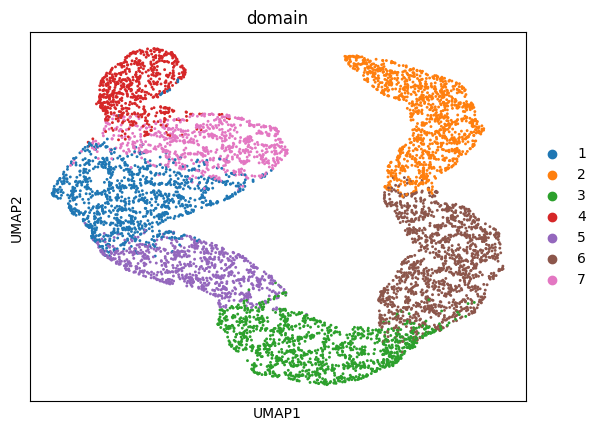

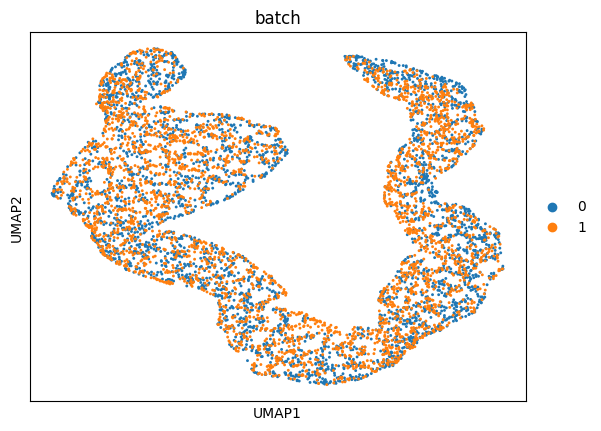

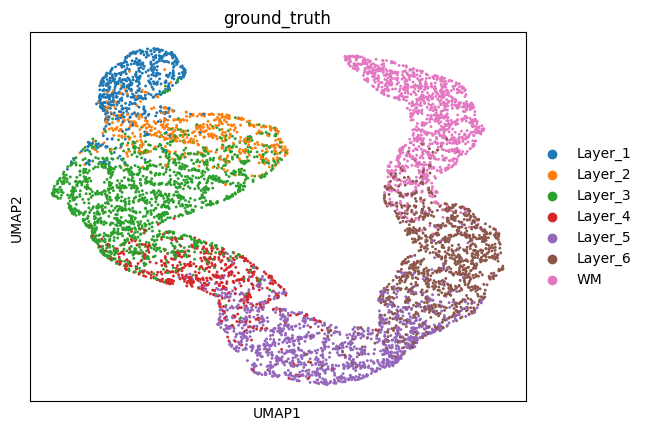

In [6]:
staig.draw_umap()